### Distribution Fitting: Generalized Error Distribution

In [20]:
# import packages
import numpy as np
import pandas as pd
import scipy.special as spsp
import scipy.optimize as spop
import yfinance as yf
import matplotlib.pyplot as plt

generalized error (generalized normal) distribution

probability density function: f(x) = shape/(2*scale*gamma(1/shape))*e^(-(abs((x-loc)/scale))^shape)

cumulative distribution function: F(x) = 1/2 + sign(x - loc)/2*gammainc(1/shape, (abs(x-loc)/scale)^shape)

if shape = 1: Laplace distribution, if shape=2: normal distribution

In [21]:
# specify the sample
ticker = '^FTSE'
start_date = '2019-05-25'
end_date = '2024-05-25'

In [22]:
# retrieve data
prices = yf.download(ticker, start_date, end_date)['Close']

[*********************100%%**********************]  1 of 1 completed


In [23]:
prices

Date
2019-05-28    7269.000000
2019-05-29    7185.299805
2019-05-30    7218.200195
2019-05-31    7161.700195
2019-06-03    7184.799805
                 ...     
2024-05-20    8424.200195
2024-05-21    8416.500000
2024-05-22    8370.299805
2024-05-23    8339.200195
2024-05-24    8317.599609
Name: Close, Length: 1261, dtype: float64

In [24]:
# calculate and sort returns
returns = np.array(prices[1:])/np.array(prices[:-1]) - 1
returns = np.sort(returns)
returns

array([-0.10873819, -0.07687313, -0.05251309, ...,  0.04447304,
        0.04675124,  0.09053047])

In [25]:
# construct the empirical distribution function
edf = np.arange(1, len(returns)+1)/len(returns)

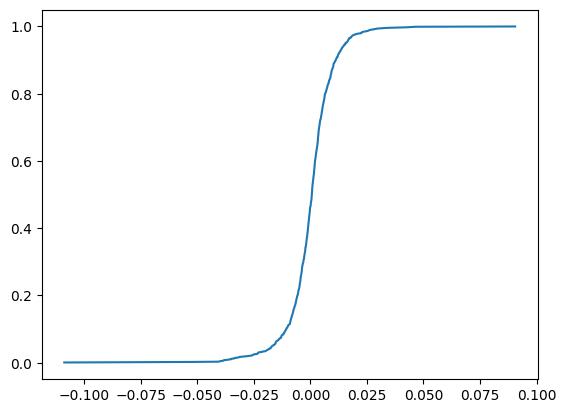

In [26]:
plt.plot(returns, edf)
plt.show()

In [27]:
#calculate mean and standard deviation
mean = np.average(returns)
std = np.std(returns)

In [28]:
# optimize generalized error distribution parameters using maximum likelihood estimation
def ged_optimization(k):
    k[1] = abs(k[1])
    k[2] = abs(k[2])
    pdf = k[2]/(2*k[1]*spsp.gamma(1/k[2]))*np.exp(-(abs(returns - k[0])/k[1])**k[2])
    return -np.sum(np.log(pdf))

In [29]:
res = spop.minimize(ged_optimization, [mean, std, 2], method='Nelder-Mead')
print(res)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -4091.8184884944512
             x: [ 6.902e-04  5.619e-03  8.595e-01]
           nit: 105
          nfev: 180
 final_simplex: (array([[ 6.902e-04,  5.619e-03,  8.595e-01],
                       [ 6.902e-04,  5.619e-03,  8.595e-01],
                       [ 6.902e-04,  5.618e-03,  8.594e-01],
                       [ 6.902e-04,  5.619e-03,  8.595e-01]]), array([-4.092e+03, -4.092e+03, -4.092e+03, -4.092e+03]))


In [30]:
# retrieve optimal distribution parameters
ged_loc = res.x[0]
ged_scale = abs(res.x[1])
ged_shape = abs(res.x[2])
print("The shape parameter of the best fitting distibution equals "+ str(round(ged_shape, 4)))

The shape parameter of the best fitting distibution equals 0.8595


In [31]:
# Calculate the cumulative distribution function 
cdf = 1/2 + np.sign(returns - ged_loc)/2*spsp.gammainc(1/ged_shape, (abs(returns - ged_loc)/ged_scale)**ged_shape)

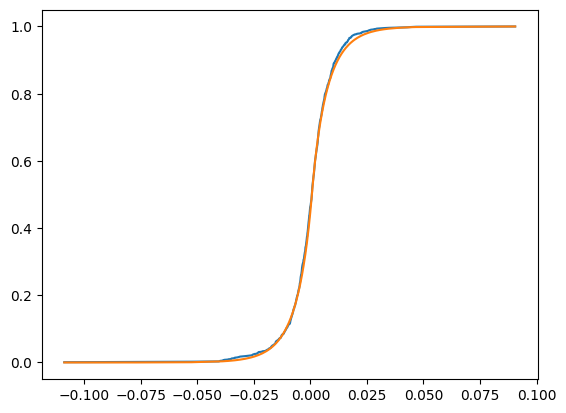

In [32]:
# visualize the distribution functions
plt.plot(returns, edf)
plt.plot(returns, cdf)
plt.show()

In [33]:
# evaluate the goodness of fit using Kolmogorov Smirnov Test
supremum = max(abs(edf - cdf))
p_value = np.exp(-supremum**2*len(returns))
print('p-value of the Kolmogorov-Smirnov Test equals ' + str(round(p_value*100, 4))+'%')
if p_value < 0.1:
    print("The distribution does not fit the data")
else:
    print("The distribution fits the data")

p-value of the Kolmogorov-Smirnov Test equals 52.417%
The distribution fits the data
